## Visualize input audio waveform

In [1]:
import librosa
from matplotlib import pyplot as plt 

In [7]:
data, samplerate = librosa.load("../../tests/jfk.flac", sr=16000)

In [167]:
data

array([-3.1826513e-08, -5.7742401e-08, -6.5911493e-08, ...,
       -7.7829091e-03, -1.8314138e-02, -1.4547420e-02], dtype=float32)

In [168]:
data.shape

(176000,)

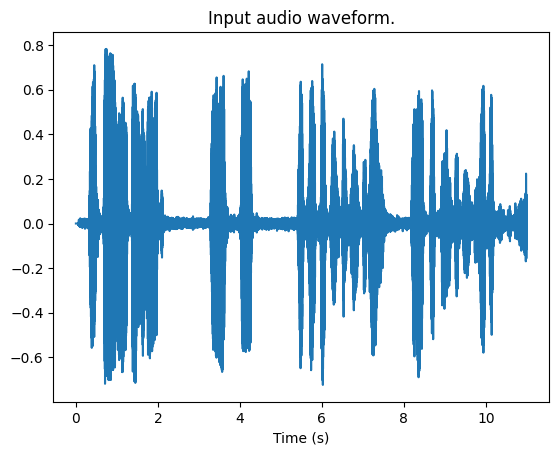

In [11]:
plt.title("Input audio waveform.")
plt.xlabel("Time (s)")
x = [i / samplerate for i in range(data.shape[0])]
plt.plot(x, data)
plt.show()

## Load model and processor

In [12]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

/Users/emiliomarinone/Repos/whisper/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
processor = WhisperProcessor.from_pretrained("openai/whisper-large")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large")

## Visualize log-mel spectrogram

In [15]:
input_features = processor(data, return_tensors="pt").input_features

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


In [176]:
input_features

tensor([[[-0.5387, -0.5387, -0.5387,  ..., -0.5387, -0.5387, -0.5387],
         [-0.5387, -0.5387, -0.5387,  ..., -0.5387, -0.5387, -0.5387],
         [-0.5387, -0.5387, -0.5387,  ..., -0.5387, -0.5387, -0.5387],
         ...,
         [-0.5387, -0.5387, -0.5387,  ..., -0.5387, -0.5387, -0.5387],
         [-0.5387, -0.5387, -0.5387,  ..., -0.5387, -0.5387, -0.5387],
         [-0.5387, -0.5387, -0.5387,  ..., -0.5387, -0.5387, -0.5387]]])

In [181]:
input_features.max(), input_features.min(), input_features.mean(), input_features.std()

(tensor(1.4613), tensor(-0.5387), tensor(-0.2950), tensor(0.4221))

In [75]:
import math

import torchvision.transforms as T


transform = T.ToPILImage()
audio_duration = data.shape[0] / samplerate
log_mel_size = math.ceil(audio_duration * 100)

img = transform(input_features[:,:,:log_mel_size])
img.show()

## Inspect tokenizer

In [149]:
original_input = "This is a tokenization example"
token_ids = processor.tokenizer.encode(original_input)
tokens = processor.tokenizer.batch_decode(token_ids)
reconstructed_input = processor.tokenizer.decode(token_ids)
assert original_input == reconstructed_input, f"{original_input = } != {reconstructed_input = }"

In [153]:
original_input

'This is a tokenization example'

In [151]:
tokens

['This', ' is', ' a', ' ', 't', 'oken', 'ization', ' example']

In [152]:
token_ids

[5723, 307, 257, 220, 83, 8406, 2144, 1365]

In [154]:
reconstructed_input

'This is a tokenization example'

## Example of embedding of 5 tokens with embedding_dim = 10

In [138]:
import numpy as np


In [141]:
np.random.uniform(low=-1, size=(5,10))

[5723, 307, 257, 220, 83, 8406, 2144, 1365]

## Whisper's embedding

In [142]:
import torch

In [143]:
t = torch.tensor(token_ids)
t

tensor([5723,  307,  257,  220,   83, 8406, 2144, 1365])

In [146]:
t.shape

torch.Size([8])

In [144]:
embeddings = model.model.decoder.embed_tokens(t)
embeddings

tensor([[-0.0014, -0.0077,  0.0017,  ..., -0.0049,  0.0080,  0.0095],
        [ 0.0061,  0.0101, -0.0050,  ...,  0.0026, -0.0058,  0.0113],
        [-0.0031,  0.0004,  0.0324,  ...,  0.0125, -0.0039,  0.0029],
        ...,
        [-0.0028, -0.0133, -0.0061,  ..., -0.0118,  0.0086,  0.0071],
        [-0.0139, -0.0101, -0.0157,  ..., -0.0128,  0.0046,  0.0005],
        [-0.0026, -0.0127, -0.0026,  ..., -0.0009,  0.0128,  0.0120]],
       grad_fn=<EmbeddingBackward0>)

In [145]:
embeddings.shape

torch.Size([8, 1280])

## Inspect "task" tokens

In [182]:
model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="en", task="transcribe", no_timestamps=True)

In [183]:
decoder_input = model.config.forced_decoder_ids
decoder_input

[(1, 50259), (2, 50359), (3, 50363)]

In [100]:
processor.batch_decode(decoder_input)

['"<|en|>', '#<|transcribe|>', '$<|notimestamps|>']

In [101]:
print(processor.decode(1))
print(processor.decode(2))
print(processor.decode(3))

"
#
$


In [103]:
decoder_input_values = [kv[1] for kv in decoder_input]
decoder_input_values

[50259, 50359, 50363]

In [104]:
processor.batch_decode(decoder_input_values)

['<|en|>', '<|transcribe|>', '<|notimestamps|>']

## Transcribe

In [31]:
resp = model.generate(
    input_features,
    do_sample=True,
    num_return_sequences=1,
    num_beams=1,
    num_beam_groups=1
)

/Users/emiliomarinone/Repos/whisper/venv/lib/python3.9/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 448 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [107]:
resp.shape

torch.Size([1, 30])

In [184]:
resp

tensor([[50258, 50259, 50359, 50363,   400,   370,   452,  7177,  6280,    11,
          1029,   406,   437,   428,  1941,   393,   360,   337,   291,    11,
          3365,   437,   291,   393,   360,   337,   428,  1941,    13, 50257]])

In [185]:
resp[0].shape

torch.Size([30])

In [164]:
[processor.tokenizer.decode(token) for token in resp[0]]

['<|startoftranscript|>',
 '<|en|>',
 '<|transcribe|>',
 '<|notimestamps|>',
 ' And',
 ' so',
 ' my',
 ' fellow',
 ' Americans',
 ',',
 ' ask',
 ' not',
 ' what',
 ' your',
 ' country',
 ' can',
 ' do',
 ' for',
 ' you',
 ',',
 ' asking',
 ' what',
 ' you',
 ' can',
 ' do',
 ' for',
 ' your',
 ' country',
 '.',
 '<|endoftext|>']

In [186]:
processor.decode(resp[0])

'<|startoftranscript|><|en|><|transcribe|><|notimestamps|> And so my fellow Americans, ask not what your country can do for you, asking what you can do for your country.<|endoftext|>'

In [188]:
processor.decode(resp[0], skip_special_tokens=True)

' And so my fellow Americans, ask not what your country can do for you, asking what you can do for your country.'

In [166]:
processor.decode(resp[0], skip_special_tokens=True).strip()

'And so my fellow Americans, ask not what your country can do for you, asking what you can do for your country.'